In [1]:
import time
start_time = time.time()
def time_check(start=None):
    if start:
        t = time.time() - start
    else:
        t = time.time() - start_time
    print(f'Time check: {t//60:.0f} minutes and {t%60:.0f} seconds')

The dataset used in this notebook was compiled by me in several other notebooks. See the `compile_and_filter_dataset` folder in this repository for the detailed process of how the data was collected. Here is a summary of the work done to collect this data.

#### 1. Get movie discussions
Use the PRAW library, a wrapper for the Reddit API.
* Collect the URLs and titles for all available official movie discussions on Reddit's r/movies. This should be 1,000 rows. 
    * Filter out discussions not related to movies, such as discussions of award ceremonies and end-of-year threads.
    * Use RegEx to clean up movie titles. Strip words from the post's title like
        * "official discussion"
        * "spoilers"
        * "international release"
    *  Save resulting dataframe as `movies_cleaned.csv`.

#### 2. Get comments from movies
Using PRAW and the URLS collected in the last notebook:
* Get the top 100 comments from each discussion thread (some will have fewer than 100) as well as the date the thread was posted.
    * The date will be useful when trying to match the Reddit post with the movie's IMDb score.
    * Save comments and dates in a dictionary format with the discussion's Reddit ID as the key.
    * This dictionary should be read as a dataframe and transposed.
* Save the resulting dictionary as a JSON file `movies_comments.json`.

#### 3. Clean comments
Using the previously saved JSON file:
* Read it in as a dataframe.
* Combine the comments from movies that were discussed on Reddit twice. Some movies had an discussions for international releases and US releases. Choose one post and ID to act as the ID for this movie.
    * This requires some granular work, since some movies simply have the same title, etc.
* Save this dataframe as a CSV, excluding the comments, as `reddit_movies_final.csv`.
* Explode comments. Resulting dataframe should have tens of thousands of rows.
* Drop duplicate comments.
    * More granular work here. Not all duplicates should be dropped. Only ones that appear to be spam or administrative.
* Remove administrative comments from each discussion. They only show up in a few discussions, but they are usually the first comment and contain keywords like "r/movies", "pinned", or "FYI".
* Save the resulting dataframe as `comments_exploded.csv`.

#### 4. Merge movies with IMDb score
* Download IMDb datasets "title.basics.tsv.gz" and "title.ratings.tsv.gz" from https://www.imdb.com/interfaces/
* Read in the datasets as dataframes. Drop non-movies and merge them on the unique identifier.
* Merge this IMDb dataset with the Reddit movies dataset. Use movie title and release date as the features to merge on.
    * Filter out duplicates. A surprising number of blockbuster movies share a release year and title with other, lesser known movies.
        * This requires granular work and care. Some Reddit movies might match with the wrong IMDb movie. Some Reddit movies were discussed in the year after the movie was released.
    * Some movies in the Reddit dataframe need their titles changed to match the IMDb counterpart (misspelled).
* Merge the resulting dataset with the comments dataset.
* Save resulting data as `data_final.csv`.

In [2]:
import numpy as np
import pandas as pd
import warnings
import datetime

from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
from spacy import displacy

from scipy.stats import pearsonr, spearmanr, kendalltau

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, r2_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import RootMeanSquaredError, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

from transformers import pipelines

import re
from collections import OrderedDict, Counter
import itertools
import string

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

import praw

import json

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 100
seed = 55
np.random.seed(seed)

## Data Preparation

### Read in final dataset, containing reddit comments and IMDb scores.

In [3]:
df = pd.read_csv('./data/data_final.csv')

In [4]:
df.head()

,id,tconst,title,originalTitle,comments,runtimeMinutes,startYear,post_date_utc,post_year,post_month,post_day,genres,numVotes,averageRating
0,vzcwal,tt13406136,the princess,The Princess,Joey King needs a new agent. She’s proven she has talent but she has so many terrible films on h...,94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
1,vzcwal,tt13406136,the princess,The Princess,"Silly, but entertaining and non stop action",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
2,vzcwal,tt13406136,the princess,The Princess,"The yassification of The Raid\n\nActually, this was fun enough and mad respect to Joey King for ...",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
3,vzcwal,tt13406136,the princess,The Princess,"Honestly, this was pretty fun. The plot is nothing special yes.\n\nBut Joey King was actually e...",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
4,vzcwal,tt13406136,the princess,The Princess,"Man, I loved this movie. Yeah, it was campy, but whatever. The premise worked for me, I liked th...",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              70692 non-null  object 
 1   tconst          70692 non-null  object 
 2   title           70692 non-null  object 
 3   originalTitle   70692 non-null  object 
 4   comments        70692 non-null  object 
 5   runtimeMinutes  70692 non-null  float64
 6   startYear       70692 non-null  int64  
 7   post_date_utc   70692 non-null  float64
 8   post_year       70692 non-null  int64  
 9   post_month      70692 non-null  int64  
 10  post_day        70692 non-null  int64  
 11  genres          70621 non-null  object 
 12  numVotes        70692 non-null  int64  
 13  averageRating   70692 non-null  float64
dtypes: float64(3), int64(5), object(6)
memory usage: 7.6+ MB


### "Imploding" the dataframe

Currently, each comment is its own row, making the dataset over 70,000 rows.

In reality, each of these comments corresponds to one of about 900 movies.

That's how I'm going to be dealing with this data from now own, so I will compress all the comments into lists.

In [6]:
comments_imploded = df.groupby('id')['comments'].agg(list)

In [7]:
df = df.drop_duplicates(subset='id').drop(columns=['comments'])
df = df.join(comments_imploded, on='id')
df ['n_comments'] = df['comments'].apply(len)
df.head()

,id,tconst,title,originalTitle,runtimeMinutes,startYear,post_date_utc,post_year,post_month,post_day,genres,numVotes,averageRating,comments,n_comments
0,vzcwal,tt13406136,the princess,The Princess,94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6,[Joey King needs a new agent. She’s proven she has talent but she has so many terrible films on ...,21
21,vzcw0a,tt11671006,the man from toronto,The Man from Toronto,110.0,2022,1.657851e+09,2022,7,14,"Action,Adventure,Comedy",43386,5.8,[ O offence to Woody but I feel like the original casting of Jason Statham would have at least i...,23
44,vzcvsd,tt9288046,the sea beast,The Sea Beast,115.0,2022,1.657851e+09,2022,7,14,"Adventure,Animation,Comedy",35834,7.1,[Absolutely crazy that Netflix dropped this and also The Mitchells Vs The Machines with almost n...,77
121,vzcvkz,tt5151570,mrs harris goes to paris,Mrs. Harris Goes to Paris,115.0,2022,1.657851e+09,2022,7,14,"Comedy,Drama",4798,7.1,"[This was so cute it just made me smile the whole time. Highly recommend., The only word for th...",22
143,vzcv66,tt9411972,where the crawdads sing,Where the Crawdads Sing,125.0,2022,1.657851e+09,2022,7,14,"Drama,Mystery,Thriller",28694,7.1,[I did enjoy her house representing the 2 different ways the men treated her . Tate was invited ...,93


Reducing the dataset to only *potentially* relevant features, although I may not use all.

In [8]:
df = df[[
    'id', 'tconst', 'title', 'averageRating', 'numVotes',
    'runtimeMinutes', 'genres', 'comments', 'n_comments'
    ]]

In [9]:
df.isna().sum()

id                0
tconst            0
title             0
averageRating     0
numVotes          0
runtimeMinutes    0
genres            1
comments          0
n_comments        0
dtype: int64

The only feature with a missing values is `genre`.

In [10]:
df[df['genres'].isna()]

,id,tconst,title,averageRating,numVotes,runtimeMinutes,genres,comments,n_comments
2378,t0tapr,tt15374070,studio 666,5.7,7356,106.0,NaN,"[Scooby Foo, As “okay” as the film is, the chainsaw double kill was absolutely gnarly., There’s ...",71


I'm not sure why this wasn't in the dataset, but on IMDb's website, this movie's genres are comedy, horror, music.

In [11]:
df.loc[2378, 'genres'] = "Comedy,Horror,Music"

### Visualizing the distribution of the target variable `averageRating`

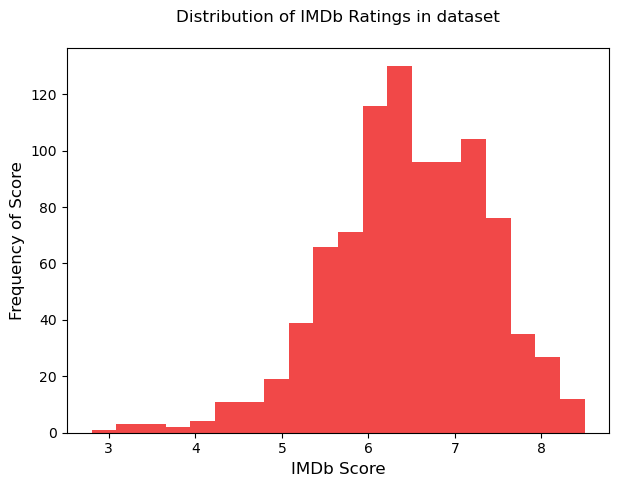

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
df['averageRating'].hist(ax=ax, color='#f14848', bins=20, grid=False)
ax.set_title('Distribution of IMDb Ratings in dataset\n')
ax.set_xlabel('IMDb Score', size=12),
ax.set_ylabel('Frequency of Score', size=12)
fig.set_facecolor('white')

In [13]:
df['averageRating'].describe()

count    922.000000
mean       6.471909
std        0.893870
min        2.800000
25%        6.000000
50%        6.500000
75%        7.100000
max        8.500000
Name: averageRating, dtype: float64

In [14]:
######################
# Visualize anything else here?
#######################

In [15]:
###################
# DISCUSS THIS DISTRUBUTION
###################

In [16]:
################################################

### Train-Test Split

In [17]:
features = df.drop(columns=['averageRating'])
target = df['averageRating']

X_train: Used for training the model and extracting meta-data about comments

X_val: Used for selecting a model

X_test: Used to score the final model

In [18]:
# Splitting the full dataset into training and testing data

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=seed
)

# Splitting off a validation set

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=.5, random_state=seed
)

### Cleaning and tokenizing comments

In [19]:
def clean_comments(comments_list):
    
    # Make everything lowercase
    cleaned = [comment.lower() for comment in comments_list]

    # Replace URLs with "HYPERLINK"
    cleaned = [re.sub(pattern=r'http\S+', repl='HYPERLINK', string=comment) for comment in cleaned]

    # Remove excessive white space and newlines
    cleaned = [comment.replace("\n", " ") for comment in cleaned]
    cleaned = [re.sub(pattern=r' {2,}', repl=' ', string=comment) for comment in cleaned]

    # Ensure apostrophes and quotation marks are consistent
    cleaned = [re.sub(r"’|‘", repl="'", string=comment) for comment in cleaned]
    cleaned = [re.sub(r"“|”", repl='"', string=comment) for comment in cleaned]
    
    return cleaned

In [20]:
X_train['comments'] = X_train['comments'].apply(clean_comments)

In [21]:
##########
# WHY NOT REMOVE PUNCTUATION?
##########

**Setting up a tokenizer with SpaCy**

In [22]:
# Disabling certain components to keep it light

nlp = spacy.load(
    "en_core_web_sm",
    disable=[
        "ner", "textcat", "custom",
        "entity_linker", "entity_linker",
        "textcat_multilabel", "transformer"
    ]
    )

In [23]:
# List of comments to use an example
example_comments = X_train.loc[3957]['comments']
display(example_comments[:3])

["best gag: start of the riddler's vlog thanking his followers for commenting",
 'confirmed: the riddler is a reddit mod',
 'i can watch batman slowly walking to 4 piano notes all day']

In [24]:
# How Spacy's "nlp" object works:

print("Spacy Object:")
print(nlp.pipe(example_comments))
print()
print("The result is a list of docs:")
print(list(nlp.pipe(example_comments))[:3])
print()
print("Type:")
print(type((list(nlp.pipe(example_comments)))[0]))
print()
print("Tokens:")
print([t.text for t in list(nlp.pipe(example_comments))[0]])

Spacy Object:
<generator object Language.pipe at 0x00000286D053E900>

The result is a list of docs:
[best gag: start of the riddler's vlog thanking his followers for commenting, confirmed: the riddler is a reddit mod, i can watch batman slowly walking to 4 piano notes all day]

Type:
<class 'spacy.tokens.doc.Doc'>

Tokens:
['best', 'gag', ':', 'start', 'of', 'the', 'riddler', "'s", 'vlog', 'thanking', 'his', 'followers', 'for', 'commenting']


The tokenizing process appears to work. It treats most punctuation as tokens, so I will likely add punctuation to my stop word list.

New column: Converting each reddit discussion into a list of SpaCy docs. Each doc is a comment.

In [25]:
# This cell can take over 7 minutes to run

X_train['spacy_comments'] = X_train['comments'].apply(lambda x: list(nlp.pipe(x)))

#### Tokinizing

In [26]:
def spacy_tokenize(list_of_docs):
    """
    Takes in a list of SpaCy documents.
    Converts them into one giant list of tokens as strings.    
    """
    tokens_by_doc = [[t.text for t in doc] for doc in list_of_docs]
    tokens_all_together = list(itertools.chain.from_iterable(tokens_by_doc))
    return tokens_all_together

In [27]:
X_train['tokens'] = X_train['spacy_comments'].apply(spacy_tokenize)

In [28]:
X_train.head()

,id,tconst,title,numVotes,runtimeMinutes,genres,comments,n_comments,spacy_comments,tokens
5057,s4a7gj,tt10095582,the tragedy of macbeth,33175,105.0,"Drama,Mystery,Thriller","[kathryn hunter playing all 3 witches and the old man was phenomenal, while i was lost some with...",96,"[(kathryn, hunter, playing, all, 3, witches, and, the, old, man, was, phenomenal), (while, i, wa...","[kathryn, hunter, playing, all, 3, witches, and, the, old, man, was, phenomenal, while, i, was, ..."
2183,u93jxh,tt11291274,the unbearable weight of massive talent,71143,107.0,"Action,Comedy,Crime",[nic cage and pedro pascal tripping balls and having an emotional crisis over an 8 ft wall will ...,97,"[(nic, cage, and, pedro, pascal, tripping, balls, and, having, an, emotional, crisis, over, an, ...","[nic, cage, and, pedro, pascal, tripping, balls, and, having, an, emotional, crisis, over, an, 8..."
40719,a5yk8k,tt7905466,they shall not grow old,34675,99.0,"Documentary,History,War","[biggest takeaway is the brit's will do just about anything to get their cup of tea. , >""they sh...",117,"[(biggest, takeaway, is, the, brit, 's, will, do, just, about, anything, to, get, their, cup, of...","[biggest, takeaway, is, the, brit, 's, will, do, just, about, anything, to, get, their, cup, of,..."
2044,ueb30t,tt12519030,hatching,6807,91.0,Horror,[the only monster in this movie was the bitch of a mother. i liked the character design of the e...,22,"[(the, only, monster, in, this, movie, was, the, bitch, of, a, mother, ., i, liked, the, charact...","[the, only, monster, in, this, movie, was, the, bitch, of, a, mother, ., i, liked, the, characte..."
67123,4ukw1u,tt4853102,batman: the killing joke,56967,76.0,"Action,Animation,Crime","[batman doing batgirl in cowgirl position is like something out of a bad porn parody. and sure, ...",97,"[(batman, doing, batgirl, in, cowgirl, position, is, like, something, out, of, a, bad, porn, par...","[batman, doing, batgirl, in, cowgirl, position, is, like, something, out, of, a, bad, porn, paro..."


In [29]:
time_check()

Time check: 5 minutes and 54 seconds


**Stop words**

To make a comprehensive list of stop words, I will combine the default lists from the NLTK and SpaCy libraries.

In [30]:
sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
punct = [p for p in string.punctuation]
stopword_list = list(set(sw_spacy + sw_nltk + punct))

In [31]:
len(stopword_list)

414

Are there any other other words I should include in stop words?

C:\Users\zshoo\AppData\Local\Temp\ipykernel_22316\2472491179.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tokens, rotation=45, ha='right')


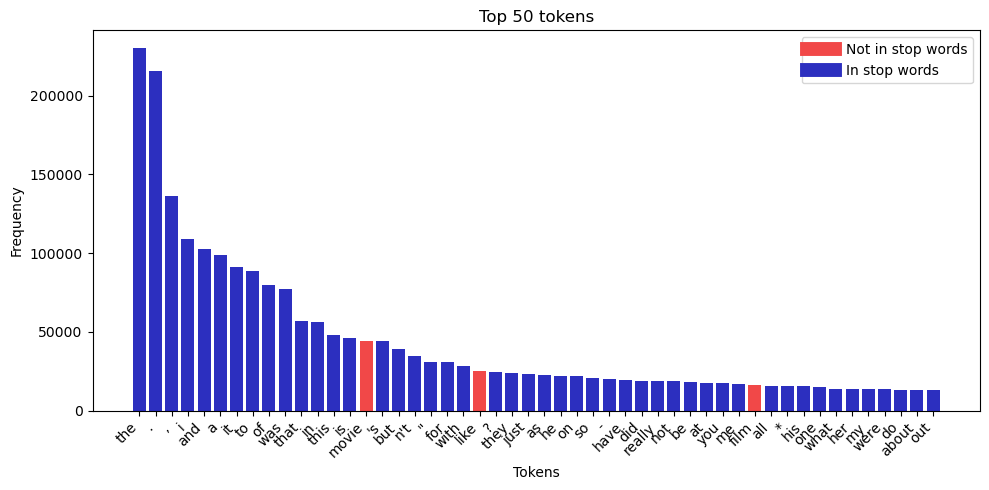

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

top_50_tok = OrderedDict(
    FreqDist(X_train['tokens'].explode()).most_common(50)
    )

tokens = list(top_50_tok.keys())
freq = list(top_50_tok.values())
extra_sw = [t for t in tokens if t not in stopword_list]
ax.bar(x=tokens, height=freq, color=['#f14848' if t in extra_sw else '#2c2fbf' for t in tokens])
ax.set_ylabel('Frequency', size=10)
ax.set_xlabel('Tokens', size=10)
ax.set_xticklabels(tokens, rotation=45, ha='right')
ax.set_title('Top 50 tokens')
custom_bars = [Line2D([0], [0], color='#f14848', lw=10), Line2D([0], [0], color='#2c2fbf', lw=10)]
ax.legend(custom_bars, ['Not in stop words', 'In stop words'], fontsize=10)
fig.set_facecolor('white');
plt.tight_layout()
# plt.savefig(f'./images/top_50_tokens', dpi=500)
plt.show()

The tokens **movie**, **like**, and **film** occur as frequently as many stop words. I'll add them to the stop word list. These words get thrown around so often in r/movies that they probably don't contribute much value in an ML context.

In [33]:
stopword_list.extend(["movie", "like", "film"])

#### Making tokens without stop words:

In [34]:
X_train['tokens_no_sw'] = X_train['tokens'].apply(
    lambda x: [t for t in x if t not in stopword_list]
)

Seeing most frequent tokens without stopwords:

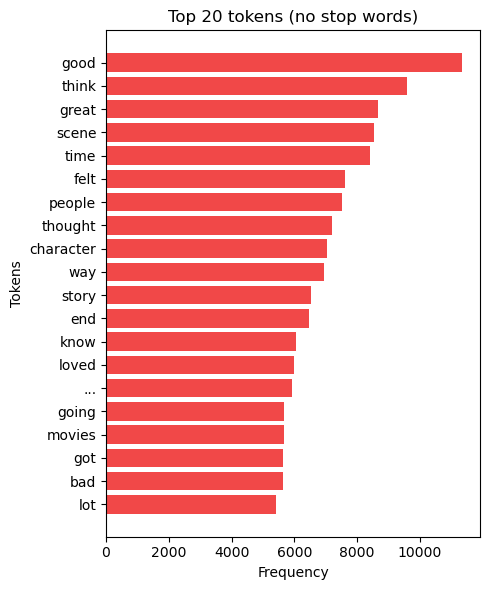

In [35]:
fig, ax = plt.subplots(figsize=(5,6))

top_20_tok = OrderedDict(
    FreqDist(X_train['tokens_no_sw'].explode()).most_common(20)
    )

tokens = list(top_20_tok.keys())[::-1]
freq = list(top_20_tok.values())[::-1]
ax.barh(y=tokens, width=freq, color='#f14848')
ax.set_ylabel('Tokens', size=10)
ax.set_xlabel('Frequency', size=10)
ax.set_title('Top 20 tokens (no stop words)')
fig.set_facecolor('white');
plt.tight_layout()
# plt.savefig(f'./images/top_20_tokens_no_sw', dpi=500)
plt.show()

Interesting that commenters used elipses ("...") often enough that it's in the top 20 tokens.

Previewing the restulting features:

In [36]:
X_train.sample(5)

,id,tconst,title,numVotes,runtimeMinutes,genres,comments,n_comments,spacy_comments,tokens,tokens_no_sw
53296,7jwxnd,tt2527336,star wars: episode viii - the last jedi,624939,152.0,"Action,Adventure,Fantasy","[""luke skywalker projecting a force ghost across the galaxy to fuck with kylo ren"" is the level ...",182,"[("", luke, skywalker, projecting, a, force, ghost, across, the, galaxy, to, fuck, with, kylo, re...","["", luke, skywalker, projecting, a, force, ghost, across, the, galaxy, to, fuck, with, kylo, ren...","[luke, skywalker, projecting, force, ghost, galaxy, fuck, kylo, ren, level, asshole, truly, aspi..."
38838,alv2d1,tt7043012,velvet buzzsaw,61264,113.0,"Horror,Mystery,Thriller","[oh no bryson look out! oh my god, he's got airpods in, he can't hear us! oh fuck!, the pacing o...",92,"[(oh, no, bryson, look, out, !, oh, my, god, ,, he, 's, got, airpods, in, ,, he, ca, n't, hear, ...","[oh, no, bryson, look, out, !, oh, my, god, ,, he, 's, got, airpods, in, ,, he, ca, n't, hear, u...","[oh, bryson, look, oh, god, got, airpods, hear, oh, fuck, pacing, atrocious, incredibly, long, b..."
6652,qxv3pk,tt9620288,king richard,106363,144.0,"Biography,Drama,Sport","[this is a great example of a straightforward, formulaic movie elevated by \*excellent\* perform...",99,"[(this, is, a, great, example, of, a, straightforward, ,, formulaic, movie, elevated, by, \*exce...","[this, is, a, great, example, of, a, straightforward, ,, formulaic, movie, elevated, by, \*excel...","[great, example, straightforward, formulaic, elevated, \*excellent\, performances, solid, direct..."
24543,fafwsf,tt1051906,the invisible man,224503,124.0,"Drama,Horror,Mystery",[the sister's reaction to the email annoyed the shit out of me. you and your sister are supposed...,99,"[(the, sister, 's, reaction, to, the, email, annoyed, the, shit, out, of, me, ., you, and, your,...","[the, sister, 's, reaction, to, the, email, annoyed, the, shit, out, of, me, ., you, and, your, ...","[sister, reaction, email, annoyed, shit, sister, supposed, close, believe, send, scathing, chara..."
1473,uynerm,tt1745960,top gun: maverick,363671,130.0,"Action,Drama","[""what were you thinking"" ""you told me not to think!"" fucking 10/10, very impressed with the way...",99,"[("", what, were, you, thinking, "", "", you, told, me, not, to, think, !, "", fucking, 10/10), (ver...","["", what, were, you, thinking, "", "", you, told, me, not, to, think, !, "", fucking, 10/10, very, ...","[thinking, told, think, fucking, 10/10, impressed, way, included, val, kilmer, respectful, manag..."


### Further breaking down tokens
#### Lemmatization

In [37]:
###############
# WHAT IS IT
##############

In [38]:
def spacy_lemmatize(list_of_docs):
    """
    Takes in a list of SpaCy documents.
    Converts them into one giant list of lemmas as strings.    
    """
    lemmas_by_doc = [[t.lemma_.lower() for t in doc] for doc in list_of_docs]
    lemmas_all_together = list(itertools.chain.from_iterable(lemmas_by_doc))
    return lemmas_all_together

In [39]:
X_train['lemmas'] = \
    X_train['spacy_comments'].apply(spacy_lemmatize)

In [40]:
FreqDist(X_train['lemmas'].explode()).most_common(20)

[('the', 229988),
 ('be', 220930),
 ('.', 215856),
 (',', 136561),
 ('i', 126201),
 ('and', 102868),
 ('a', 99050),
 ('it', 91234),
 ('to', 89984),
 ('of', 79666),
 ('that', 56669),
 ('in', 56053),
 ('not', 54934),
 ('movie', 50135),
 ('this', 48178),
 ('do', 42628),
 ('have', 40365),
 ('but', 39436),
 ('"', 31016),
 ('for', 30741)]

#### Lemmatized stop words
In order to make the lemmatized tokens without stop words, I will also need to lemmatize the stop words.

This has to be done to the stop words while they are still within the string because SpaCy uses grammatical context to lemmatize.

In [41]:
stopword_list_lem = []

sw_lem_Series = \
    X_train['spacy_comments'].apply(
        lambda x: [[t.lemma_.lower() for t in doc if t.text.lower() in stopword_list] for doc in x]
    )

sw_lem_Series = sw_lem_Series.apply(lambda x: list(itertools.chain.from_iterable(x)))

for row in sw_lem_Series:
    stopword_list_lem.extend(row)

stopword_list_lem = list(set(stopword_list_lem))

In [42]:
# Lemmatized tokens, excluding stop words

X_train['lemmas_no_sw'] = X_train['lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list_lem]
    )

Seeing most frequent tokens without stopwords:

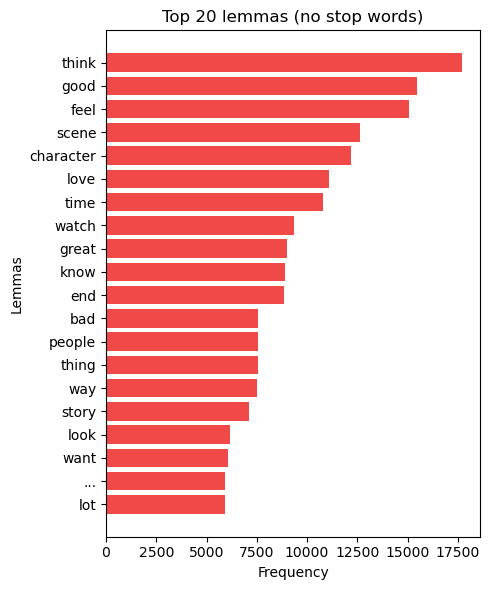

In [43]:
fig, ax = plt.subplots(figsize=(5,6))

top_20_lem = OrderedDict(
    FreqDist(X_train['lemmas_no_sw'].explode()).most_common(20)
    )

tokens = list(top_20_lem.keys())[::-1]
freq = list(top_20_lem.values())[::-1]
ax.barh(y=tokens, width=freq, color='#f14848')
ax.set_ylabel('Lemmas', size=10)
ax.set_xlabel('Frequency', size=10)
ax.set_title('Top 20 lemmas (no stop words)')
fig.set_facecolor('white');
plt.tight_layout()
# plt.savefig(f'./images/top_20_lemmas_no_sw', dpi=500)
plt.show()

In [44]:
y_train_class = y_train.apply(lambda x: int(x > y_train.mean()))

In [45]:
def plot_freqdict_classes(series, y, token_type='Tokens (unspecified kind))', cutoff=20):
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    fd_0 = FreqDist(series[y==0].explode()).most_common(cutoff)
    fd_0 = OrderedDict(fd_0)
    tokens_0 = list(fd_0.keys())[::-1]
    freq_0 = list(fd_0.values())[::-1]
    fd_1 = FreqDist(series[y==1].explode()).most_common(cutoff)
    fd_1 = OrderedDict(fd_1)
    tokens_1 = list(fd_1.keys())[::-1]
    freq_1 = list(fd_1.values())[::-1]
    shared_tokens = [t for t in tokens_0 if t in tokens_1]
    axes[0].barh(y=tokens_0, width=freq_0, color=['C6' if token in shared_tokens else 'C0' for token in tokens_0])
    axes[1].barh(y=tokens_1, width=freq_1, color=['C6' if token in shared_tokens else 'C0' for token in tokens_1])
    axes[0].set_ylabel('Tokens', size=10)
    axes[0].set_xlabel('Frequency', size=10)
    axes[1].set_xlabel('Frequency', size=10)
    fig.suptitle(f'Top {cutoff} {token_type}', size=15)
    axes[0].set_title('Below average IMDb Score')
    axes[1].set_title('Above Average average IMDb Score')
    custom_bars = [Line2D([0], [0], color='C6', lw=10), Line2D([0], [0], color='C0', lw=10)]
    axes[0].legend(custom_bars, ['In common', 'Not in common'])
    axes[1].legend(custom_bars, ['In common', 'Not in common'])
    fig.set_facecolor('white');
    plt.tight_layout()
#     plt.savefig(f'./images/top_20_{series.name}', dpi=500)
    plt.show()


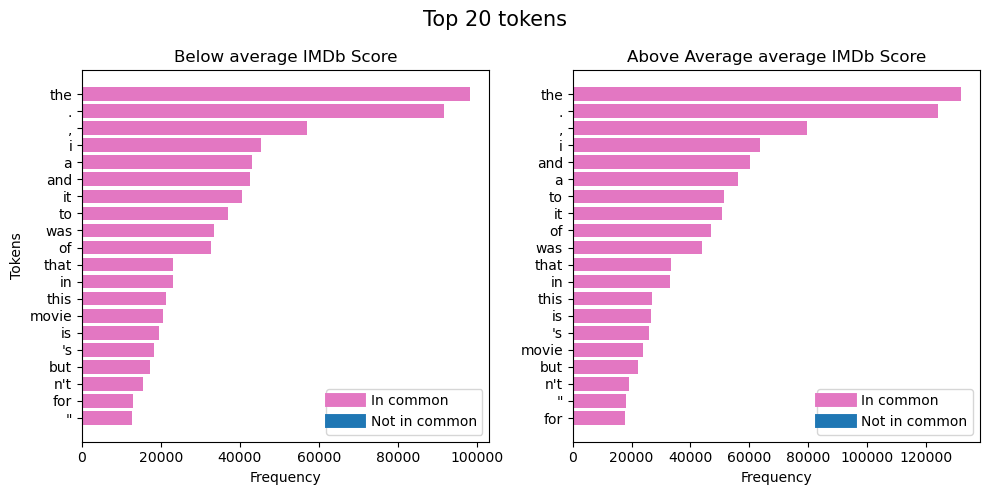

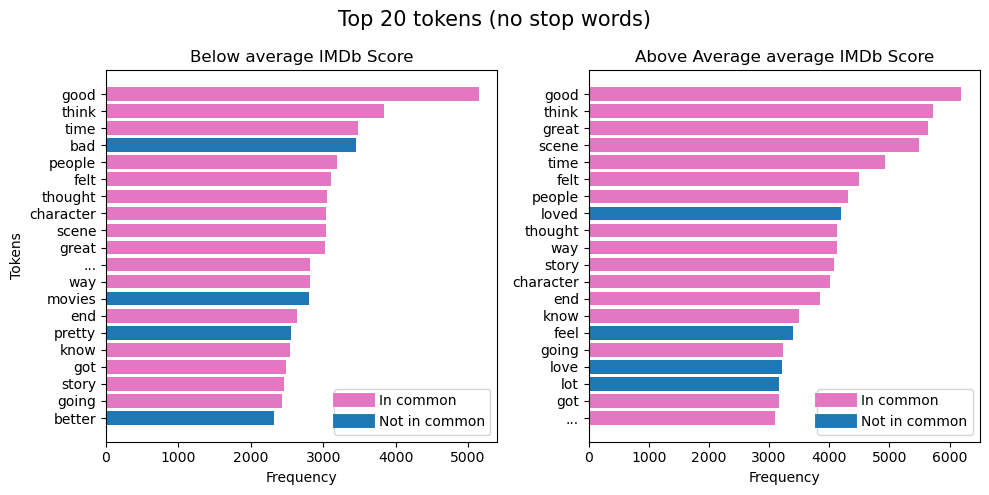

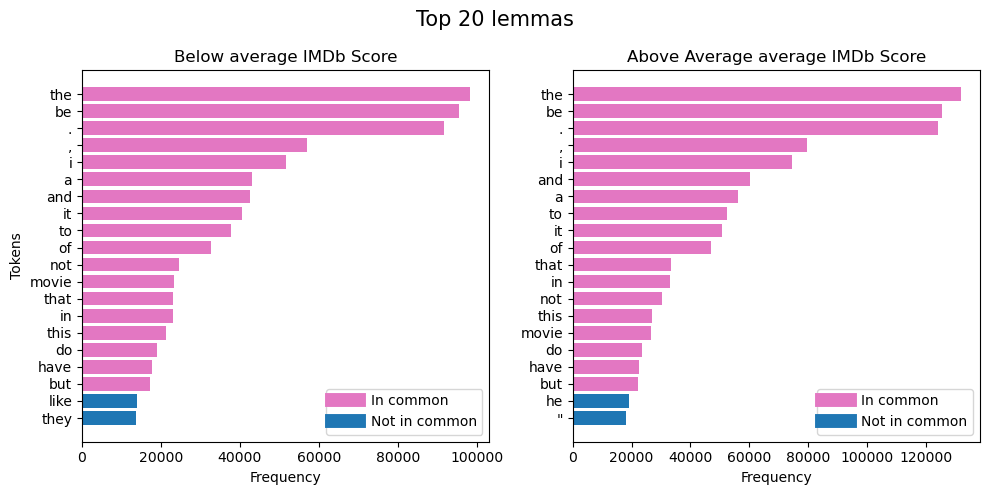

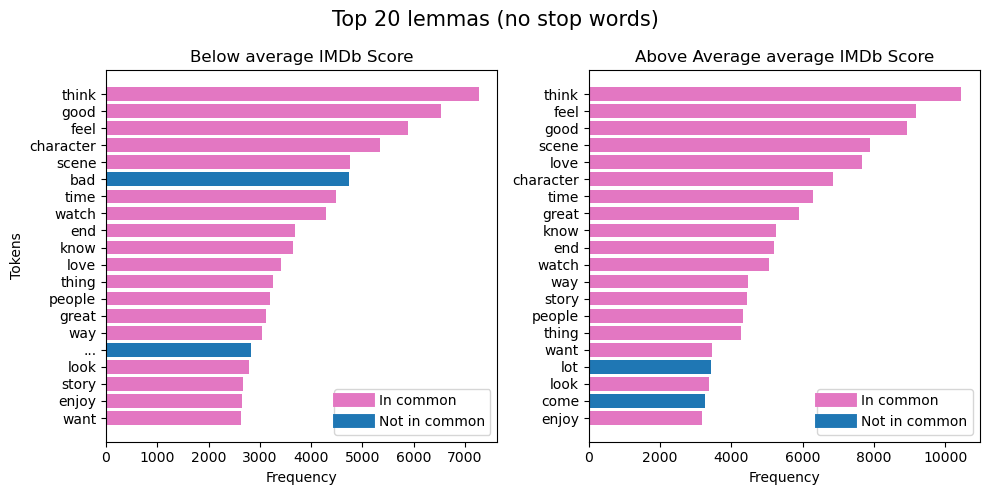

In [46]:
plot_freqdict_classes(X_train['tokens'], y_train_class, 'tokens')
plot_freqdict_classes(X_train['tokens_no_sw'], y_train_class, 'tokens (no stop words)')
plot_freqdict_classes(X_train['lemmas'], y_train_class, 'lemmas')
plot_freqdict_classes(X_train['lemmas_no_sw'], y_train_class, 'lemmas (no stop words)')

### More linguistic feature engineering
I will use the SpaCy library to extract more linguistic features from the tweets.

### Vectorized part of speech (POS) tags
The SpaCy library is pre-trained to parse through sentences and identify each word's grammatical part of speech.

Here are some examples of what the tool can identify

In [47]:
options_displacy_pos = {'compact':True, 'distance':90, 'bg':'#3056ff', 'color':'fff'}

for idx in [2, 5, 12]:
    print(example_comments[idx])
    displacy.render(nlp(example_comments[idx]), style='dep', jupyter=True, options=options_displacy_pos)

i can watch batman slowly walking to 4 piano notes all day


the whole scene with the riddler talking about "bruce wayne" had me hooked. i hope paul dano returns for the sequel.


that fight in the dark only being lit up by gunfire was absolutely incredible.


I plan to use this SpaCy capability in order to vectorize the universal [parts of speech](https://universaldependencies.org/u/pos/all.html) of each tweet.

First, I'll convert each token into a string of its POS tag.

In [48]:
def spacy_pos(list_of_docs):
    """
    Takes in a list of SpaCy documents.
    Converts them into one giant list of POS tags as strings.    
    """
    pos_by_doc = [[t.pos_ for t in doc] for doc in list_of_docs]
    pos_all_together = list(itertools.chain.from_iterable(pos_by_doc))
    return pos_all_together

In [49]:
X_train['spacy_pos'] = X_train['spacy_comments'].apply(spacy_pos)

In [50]:
time_check()

Time check: 7 minutes and 38 seconds


In order to make the POS vectors, I'm using scikit-learn's CountVectorizer in a slightly unorthodox way. I'm using it to count POS tags rather than tokens.

In [51]:
# Making dataframes of vectorized POS tags

pos_vectorizer = CountVectorizer(tokenizer=spacy_pos, lowercase=False)
pos_vec_train = pos_vectorizer.fit_transform(X_train['spacy_comments'])
pos_vec_df_train = pd.DataFrame(
        pos_vec_train.toarray(),
        columns=pos_vectorizer.get_feature_names_out(),
        index=X_train.index
)

In [52]:
pos_vec_df_train.head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SPACE,SYM,VERB,X
5057,516,542,457,421,230,584,9,1016,44,174,700,151,638,140,1,7,703,8
2183,483,468,314,342,182,457,7,906,61,132,572,153,543,107,5,8,571,9
40719,1032,1293,827,816,508,1274,10,2327,124,318,1454,160,1179,316,17,17,1587,13
2044,143,173,95,129,72,194,6,349,6,69,230,22,212,56,0,2,238,0
67123,1203,1318,1017,1192,560,1425,40,2543,132,511,1840,300,1690,373,1,18,1848,12


Changing this to the proportion of each POS in each Reddit thread.

In [53]:
pos_vec_df_norm_train = pos_vec_df_train.div(pos_vec_df_train.sum(axis=1), axis=0)
pos_vec_df_norm_train.columns = pos_vec_df_train.columns + '_norm'
pos_vec_df_norm_train.head()

,ADJ_norm,ADP_norm,ADV_norm,AUX_norm,CCONJ_norm,DET_norm,INTJ_norm,NOUN_norm,NUM_norm,PART_norm,PRON_norm,PROPN_norm,PUNCT_norm,SCONJ_norm,SPACE_norm,SYM_norm,VERB_norm,X_norm
5057,0.081375,0.085475,0.072071,0.066393,0.036272,0.092099,0.001419,0.160227,0.006939,0.027440,0.110393,0.023813,0.100615,0.022079,0.000158,0.001104,0.110866,0.001262
2183,0.090789,0.087970,0.059023,0.064286,0.034211,0.085902,0.001316,0.170301,0.011466,0.024812,0.107519,0.028759,0.102068,0.020113,0.000940,0.001504,0.107331,0.001692
40719,0.077758,0.097423,0.062312,0.061483,0.038276,0.095992,0.000753,0.175332,0.009343,0.023960,0.109554,0.012055,0.088834,0.023810,0.001281,0.001281,0.119575,0.000980
2044,0.071643,0.086673,0.047595,0.064629,0.036072,0.097194,0.003006,0.174850,0.003006,0.034569,0.115230,0.011022,0.106212,0.028056,0.000000,0.001002,0.119238,0.000000
67123,0.075080,0.082257,0.063471,0.074393,0.034950,0.088935,0.002496,0.158709,0.008238,0.031892,0.114835,0.018723,0.105473,0.023279,0.000062,0.001123,0.115334,0.000749


In [54]:
# pd.plotting.scatter_matrix(pos_vec_df_train.join(y_train), figsize=(15,10), alpha=.3);

In [55]:
########
# Pick POS tags with strongest correlation with IMDb...????
########

for col in pos_vec_df_norm_train.columns:
    print(f'{col}: {np.corrcoef(pos_vec_df_norm_train[col], y_train)[0][1]}')

ADJ_norm: -0.06478495913537205
ADP_norm: 0.2941323577383458
ADV_norm: 0.0021719832401800887
AUX_norm: -0.2641626537034314
CCONJ_norm: -0.0020459618473433806
DET_norm: -0.11921056356343923
INTJ_norm: -0.21051513953970158
NOUN_norm: 0.006276128342503658
NUM_norm: -0.171353572008547
PART_norm: -0.14441865820674007
PRON_norm: 0.06018137079967529
PROPN_norm: 0.07867343368530975
PUNCT_norm: 0.03526543194123182
SCONJ_norm: 0.10061839964644406
SPACE_norm: 0.048330782211710846
SYM_norm: -0.08277330066926013
VERB_norm: 0.04550205626471473
X_norm: -0.03927582630911943


In [56]:
# NEXT
####################
# Pick POS tags with strongest correlation with IMDb...
# Sentiment analysis???? Prob not...
# OHE Genres?
# Meta feature engineering  
# You can plot meta-features against imdb score
#######################
# Apply everything to test and val
# Modeling

In [57]:
# X_train['genres'].apply(lambda x: x.split(","))

## Meta-feature Engineering
<!-- To engineer more features, I'm going to use seemingly arbitrary information from each tweet. Here's the set of meta-features I plan to make:

Has URL (binary)
Character count
Number of stop words
Character count of non-stop words divided by total character count
Average length of tokens
Number of tokens
Number of unique tokens
Proportion of stop words
Proportion of words that are hashtags (#)
Proportion of words that are mentions (@)
I drew inspiration for some of these features from this Kaggle entry by Gunes Evitan.

With the meta-features that are token-oriented, I have an option of four different versions of tokenized tweets:

tokens
tokens without stop words
lemmas
lemmas without stop words
I'm primarily using lemmas_no_sw (lemmatized tweets with stop words removed) because that version looked the most different between classes in the previous visualization.

Making a new DataFrame composed of the meta-features I listed above: -->

In [58]:
meta_features_df_train = X_train[['n_comments']].copy()

# Average character count of comment per discussion
meta_features_df_train['avg_char_count_comments'] = \
    X_train['comments'].apply(lambda x: np.mean([len(comment) for comment in x]))

# Average lemma length per discussion. No stop words.
meta_features_df_train['mean_lemma_length'] = \
    X_train['lemmas_no_sw'].apply(lambda x: np.mean([len(l) for l in x]))

# Proportion of unique lemmas. No stop words.
meta_features_df_train['prop_unique_lemmas_no_sw'] = \
    X_train['lemmas_no_sw'].apply(lambda x: len(set(x))/len(x))

meta_features_df_train.head()

,n_comments,avg_char_count_comments,mean_lemma_length,prop_unique_lemmas_no_sw
5057,96,322.052083,6.072451,0.454383
2183,97,258.742268,5.465536,0.460233
40719,117,555.846154,5.931635,0.343349
2044,22,425.409091,5.678886,0.633431
67123,97,783.804124,5.731316,0.307252


In [59]:
# pd.plotting.scatter_matrix(meta_features_df_train.join(y_train), figsize=(15,10), alpha=.3);

In [60]:
for col in meta_features_df_train.columns:
    print(f'{col}: {pearsonr(meta_features_df_train[col], y_train)[0]}')

n_comments: 0.15629515642683664
avg_char_count_comments: 0.12959598083984386
mean_lemma_length: 0.2980967109599579
prop_unique_lemmas_no_sw: -0.1593246680569063


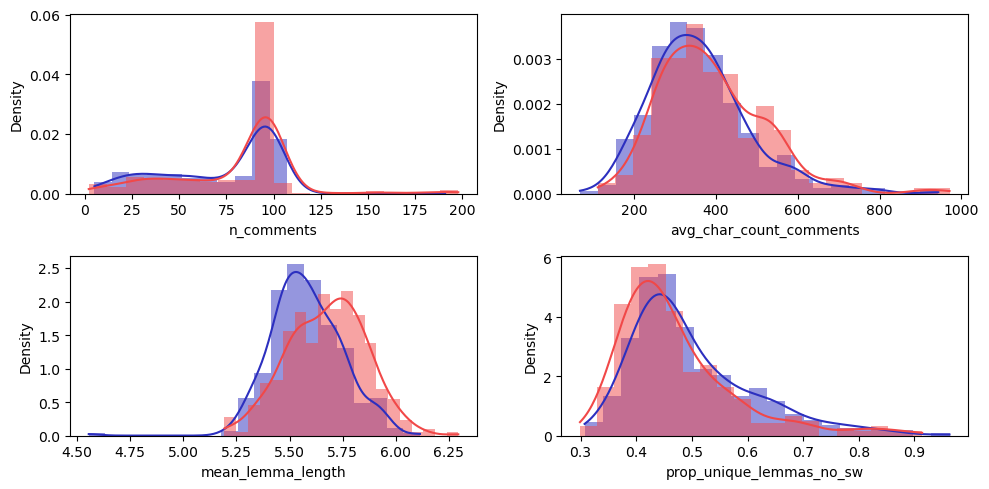

In [61]:
kwargs_histplot = {'kde':True, 'stat':"density", 'linewidth':0, 'bins':20}
color_below = '#2c2fbf'
color_above ='#f14848'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
fl_ax = axes.flatten()
fig.set_facecolor('white')
for idx, ftr in list(enumerate(meta_features_df_train.columns)):
    sns.histplot(meta_features_df_train[ftr][y_train_class==0], ax=fl_ax[idx], **kwargs_histplot, color=color_below)
    sns.histplot(meta_features_df_train[ftr][y_train_class==1], ax=fl_ax[idx], **kwargs_histplot, color=color_above)

plt.tight_layout()
# plt.savefig('./images/meta_features_basic.png', dpi=500)
plt.show()

In [62]:
################
################
################
################
################

In [63]:
tfidf = TfidfVectorizer(
    tokenizer=spacy_lemmatize, 
    stop_words=stopword_list_lem,
    max_features=500,
    lowercase=False
    )

X_train_vec = tfidf.fit_transform(X_train['spacy_comments'])

X_train_vec_df = pd.DataFrame(
    X_train_vec.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=X_train.index
    )
X_train_vec_df.head()

,..,...,....,1,10,2,20,3,30,4,...,write,writer,writing,wrong,x200b,yeah,year,yes,young,…
5057,0.012916,0.017443,0.000000,0.000000,0.000000,0.019323,0.025910,0.042898,0.027672,0.000000,...,0.031502,0.000000,0.000000,0.000000,0.000000,0.000000,0.105084,0.013447,0.000000,0.07809
2183,0.015357,0.031110,0.015033,0.014039,0.000000,0.218277,0.030809,0.051008,0.000000,0.031729,...,0.049943,0.000000,0.030527,0.013796,0.000000,0.031531,0.062475,0.015989,0.106845,0.06964
40719,0.000000,0.020725,0.006009,0.033670,0.022479,0.032144,0.006157,0.005097,0.052608,0.006341,...,0.000000,0.000000,0.000000,0.005514,0.042835,0.000000,0.099888,0.012782,0.030505,0.00000
2044,0.000000,0.039720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.023911,0.000000,0.000000,0.000000,0.000000,0.030193,0.019941,0.000000,0.029231,0.00000
67123,0.005183,0.063003,0.005074,0.023693,0.004745,0.023265,0.005199,0.004304,0.061081,0.000000,...,0.025285,0.005831,0.020607,0.018625,0.000000,0.031928,0.035145,0.016190,0.030911,0.00000


In [64]:
X_train_combined_df = pd.concat(
    [
        X_train_vec_df,
        pos_vec_df_norm_train, 
        meta_features_df_train,
    ],
    axis=1
    )

# Scaling all features

scaler = StandardScaler()
X_train_combined_df_scaled = scaler.fit_transform(X_train_combined_df)
X_train_combined_df_scaled = pd.DataFrame(X_train_combined_df_scaled, index=X_train.index, columns=X_train_combined_df.columns)

X_train_combined_df_scaled.head()

,..,...,....,1,10,2,20,3,30,4,...,PUNCT_norm,SCONJ_norm,SPACE_norm,SYM_norm,VERB_norm,X_norm,n_comments,avg_char_count_comments,mean_lemma_length,prop_unique_lemmas_no_sw
5057,-0.138585,-1.092182,-0.635194,-0.774720,-0.881553,-0.353404,0.731085,1.009756,0.899491,-0.702503,...,-0.677599,-0.290374,-0.164959,-0.305112,-0.299617,-0.394601,0.614783,-0.426230,2.408155,-0.272459
2183,-0.040000,-0.774166,0.000811,-0.117426,-0.881553,6.346455,1.008651,1.373437,-0.621487,1.000058,...,-0.501926,-0.854367,1.578321,0.212321,-0.822673,-0.101584,0.646747,-0.920188,-0.910538,-0.219001
40719,-0.660070,-1.015804,-0.380975,0.801650,0.425276,0.078331,-0.388255,-0.685442,2.270047,-0.362236,...,-2.102384,0.206263,2.338451,-0.076097,0.989056,-0.586808,1.286035,1.397887,1.638156,-1.287016
2044,-0.660070,-0.573843,-0.635194,-0.774720,-0.881553,-1.004133,-0.737167,-0.914024,-0.621487,-0.702503,...,-0.000680,1.424650,-0.516456,-0.437012,0.939255,-1.254126,-1.750581,0.380186,0.256089,1.363566
67123,-0.450782,-0.032097,-0.420528,0.334540,-0.605676,-0.220661,-0.442540,-0.721006,2.735795,-0.702503,...,-0.090056,0.054061,-0.377354,-0.279930,0.361556,-0.743899,0.646747,3.176468,0.542783,-1.616840


In [65]:
#########################
#########################

In [66]:
def preprocess_comments(
    df_to_process,
    tokenizer=spacy_tokenize,
    stop_words=stopword_list,
    lem_tokenizer=spacy_lemmatize,
    stop_words_lem=stopword_list_lem,
    trained_pos_vectorizer=pos_vectorizer,
    trained_word_vectorizer=tfidf,
    trained_scaler=scaler,
    return_scaled=True,
    return_cleaned_df=False
):
    """
    ...
    """
    comments_df = df_to_process.copy()
    
    comments_df['comments'] = comments_df['comments'].apply(clean_comments)
    comments_df['spacy_comments'] = comments_df['comments'].apply(lambda x: list(nlp.pipe(x)))

    comments_df['tokens'] = comments_df['spacy_comments'].apply(spacy_tokenize)
    comments_df['tokens_no_sw'] = \
        comments_df['tokens'].apply(lambda x: [t for t in x if t not in stop_words])

    comments_df['lemmas'] = comments_df['spacy_comments'].apply(spacy_tokenize)
    comments_df['lemmas_no_sw'] = \
        comments_df['lemmas'].apply(lambda x: [t for t in x if t not in stop_words_lem])

    pos_vec = trained_pos_vectorizer.transform(comments_df['spacy_comments'])
    pos_vec_df = pd.DataFrame(
        pos_vec.toarray(), 
        columns=trained_pos_vectorizer.get_feature_names_out(),
        index=df_to_process.index
    )
    pos_vec_df_norm = pos_vec_df.div(pos_vec_df.sum(axis=1), axis=0)
    pos_vec_df_norm.columns = pos_vec_df.columns + '_norm'

    meta_features_df = comments_df[['n_comments']].copy()
    # Average character count of comment per discussion
    meta_features_df['avg_char_count_comments'] = \
        comments_df['comments'].apply(lambda x: np.mean([len(comment) for comment in x]))
    # Average lemma length per discussion. No stop words.
    meta_features_df['mean_lemma_length'] = \
        comments_df['lemmas_no_sw'].apply(lambda x: np.mean([len(l) for l in x]))
    # Proportion of unique lemmas. No stop words.
    meta_features_df['prop_unique_lemmas_no_sw'] = \
        comments_df['lemmas_no_sw'].apply(lambda x: len(set(x))/len(x))
    
    comments_vec = trained_word_vectorizer.transform(comments_df['spacy_comments'])
    comments_vec_df = pd.DataFrame(
        comments_vec.toarray(), 
        columns=trained_word_vectorizer.get_feature_names_out(),
        index=df_to_process.index
    )
    comments_combined_df = pd.concat(
        [
            comments_vec_df,
            pos_vec_df_norm,
            meta_features_df
        ],
        axis=1
    )
    comments_combined_df_scaled = trained_scaler.transform(comments_combined_df)
    comments_combined_df_scaled = pd.DataFrame(
        comments_combined_df_scaled, 
        index=df_to_process.index, 
        columns=comments_combined_df.columns
        )

    if return_scaled:
        if return_cleaned_df:
            return {'processed':comments_combined_df_scaled, 'cleaned':comments_df}
        else:
            return comments_combined_df_scaled
    else:
        if return_cleaned_df:
            return {'processed':comments_combined_df, 'cleaned':comments_df}
        else:
            return comments_combined_df

In [67]:
X_test_combined_df_scaled = preprocess_comments(X_test)
X_val_combined_df_scaled = preprocess_comments(X_val)

In [68]:
time_check()

Time check: 9 minutes and 29 seconds


In [69]:
######################
######################

In [70]:
def plot_nn_curves(model_history):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
    fl_ax = axes.flatten()
    for idx, metric in enumerate(['loss', 'root_mean_squared_error']):
        pair = [m for m in model_history.history.keys() if metric in m]
        fl_ax[idx].plot(model_history.history[pair[0]], label=metric)
        fl_ax[idx].plot(model_history.history[pair[1]], label=metric+'_val')
        fl_ax[idx].set_xlabel('epochs')
        fl_ax[idx].set_ylabel(metric)
        fl_ax[idx].set_title(f'{metric.upper()} Evaluation')
        fl_ax[idx].legend()
        plt.tight_layout();

In [71]:
n_input = X_train_combined_df_scaled.shape[1]
n_input

522

In [72]:
# READ TABS ON HOW TO DO REGRESSION W/ TF

Evaluation:
3/3 [==============================] - 0s 4ms/step - loss: 1.3551 - root_mean_squared_error: 1.1641


{'loss': 1.355058193206787, 'root_mean_squared_error': 1.164069652557373}

R2:
3/3 [==============================] - 0s 6ms/step


-0.47051259376932353

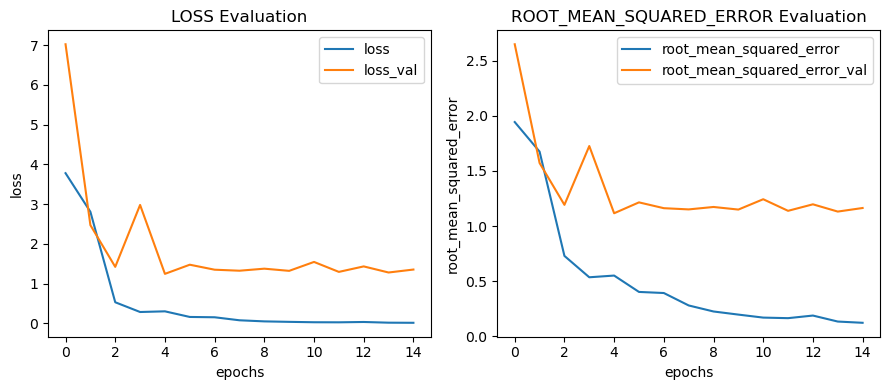

In [73]:
set_seed(seed)

model_baseline = models.Sequential()

model_baseline.add(layer=layers.Dense(
    units=round(n_input/2),
    activation='relu',
    # activation='elu',
    input_shape=(n_input,)
))

model_baseline.add(layer=layers.Dense(
    units=1,
    # activation='linear'
    ))

model_baseline.compile(
    optimizer='sgd',
    loss='mse',
    metrics=[RootMeanSquaredError()]
    )

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=10)
    ]

model_hist_baseline = model_baseline.fit(
    np.array(X_train_combined_df_scaled),
    y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_hist_baseline)
print('Evaluation:')
display(model_baseline.evaluate(X_val_combined_df_scaled, y_val, return_dict=True))
print('R2:')
display(r2_score(y_val, model_baseline.predict(X_val_combined_df_scaled)))

In [74]:
time_check()

Time check: 9 minutes and 35 seconds


In [ ]:
############################

In [ ]:
set_seed(seed)

model_baseline = models.Sequential()

model_baseline.add(layers.Dropout(0.2, input_shape=(n_input,)))

model_baseline.add(layer=layers.Dense(
    units=100,
    activation='relu',
    input_shape=(n_input,),
    kernel_regularizer=regularizers.L2(0.2)
    ))

model_baseline.add(layers.Dropout(0.2))

model_baseline.add(layer=layers.Dense(
    units=50,
    activation='relu',
    kernel_regularizer=regularizers.L2(0.2)
    ))

model_baseline.add(layers.Dropout(0.2))

model_baseline.add(layer=layers.Dense(
    units=25,
    activation='relu',
    kernel_regularizer=regularizers.L2(0.2)
    ))

# model_baseline.add(layers.Dropout(0.2))

# model_baseline.add(layer=layers.Dense(
#     units=250,
#     activation='relu',
#     kernel_regularizer=regularizers.L2(0.25)
#     ))

model_baseline.add(layer=layers.Dense(
    units=1,
    # activation='linear'
    ))

model_baseline.compile(
    optimizer='sgd',
    loss='mse',
    metrics=[RootMeanSquaredError()]
    )

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=10)
    ]

model_hist_baseline = model_baseline.fit(
    np.array(X_train_combined_df_scaled),
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=True,
    callbacks=early_stopping
)

In [ ]:
#########################################

In [ ]:
import statsmodels.api as sm

In [ ]:
def reg_qq_sced(y, X, add_constant=True, qq=True, sced=True):
    """
    Display a the summary output of a linear regression model, with predictors X and target y.

    Also displays a QQ plot and residual plot by default. These can be toggled off.
    
    The function will add a constant to the predictors by default, and this can be toggled off.
    """
    # Run a linear regression and display the summary
    if add_constant:
        X_sm = sm.add_constant(X, has_constant='add')
    else:
        X_sm = X
    model = sm.OLS(y, X_sm).fit()
    display(model.summary())

    # Display a QQ plot
    if qq:
        fig_qq = sm.graphics.qqplot(model.resid, line='45', fit=True,)
        fig_qq.suptitle('QQ plot for residual normality check')
    else:
        pass

    # Display a plot of predicted values vs. residuals
    if sced:    
        preds = model.predict(X_sm)
        residuals = model.resid
        fig_resid, ax = plt.subplots(figsize=(10,5))
        fig_resid.suptitle('Predicted vs. residual plot for homoscedasticity check')
        ax.scatter(preds, residuals, alpha=0.2)
        ax.plot(preds, [0 for i in range(len(X_sm))])
        ax.set_xlabel("Predicted Value")
        ax.set_ylabel("Actual - Predicted Value");
    else:
        pass
    print(f'Model adjusted R-squared: {model.rsquared_adj}')
    print(f'Model RMSE: {np.sqrt(model.mse_resid)}')


In [ ]:
reg_qq_sced(y_train, X_train_combined_df_scaled)